In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import brainsss
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
%matplotlib inline
plt.rcParams.update({'font.size': 20})
from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter
import nibabel as nib
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from scipy.fftpack import fft,fftshift,ifft
import tqdm

In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals = supercluster_signals.T
supercluster_signals.shape

(30456, 501)

In [3]:
supercluster_signals_fly = np.reshape(supercluster_signals,([9,3384,501]))

In [4]:
### for a given supercluster, i need to know the original median z-depth for each fly ###

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

z_corrections = []
for fly in tqdm.tqdm(fly_names):
    to_load = os.path.join(dataset_path, fly, 'warp', '20201220_warped_z_depth.nii')
    z_corrections.append(np.array(nib.load(to_load).get_data(), copy=True))
z_corrections = np.asarray(z_corrections)

superclusters_3d = np.load(os.path.join(cluster_dir, "20221130_pca_clsuters_in_luke_OG.npy"))
superclusters_3d = superclusters_3d[...,::-1] ### FLIP Z !!!!!!!!!!!!
superclusters_3d.shape

original_z_depth = []
for fly in tqdm.tqdm(range(9)):
    for cluster in range(501):
        ind = np.where(superclusters_3d==cluster)
        original_z_depth.append(np.median(z_corrections[fly,ind[0],ind[1],ind[2]]))
original_z_depth = np.asarray(original_z_depth)
original_z_depth = np.reshape(original_z_depth,(9,501))
original_z_depth = original_z_depth.astype('int')

100%|██████████| 9/9 [00:23<00:00,  2.64s/it]


In [5]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [6]:
fictrac = []
for fly in fly_names:
    
    fictrac_raw = brainsss.load_fictrac(os.path.join(dataset_path, fly, 'func_0', 'fictrac'))

    # Smooth raw fictrac data
    behavior = 'dRotLabZ'
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
    fps=50
    fictrac_smoothed = fictrac_smoothed * 180 / np.pi * fps # now in deg/sec
    fictrac.append(fictrac_smoothed)

In [7]:
fictrac_timestamps = np.arange(0,30*60*1000,20)
file = os.path.join(dataset_path, 'fly_087', 'func_0', 'imaging')
neural_timestamps = brainsss.load_timestamps(file)

Trying to load timestamp data from hdf5 file.
Success.


In [8]:
turn_thresh = 200

peaks_all_fly = []
peak_heights_all_fly = []
for fly in range(9):
    peaks = {'L':[],'R':[]}
    heights = {'L':[],'R':[]}
    for turn,scalar in zip(['L', 'R'],[1,-1]):
        
        found_peaks = scipy.signal.find_peaks(fictrac[fly]*scalar, height=turn_thresh)
        pks = found_peaks[0]
        pk_height = found_peaks[1]['peak_heights']
        
        ### remove peaks that are too close to beginning or end
        # will do 20sec window
        # here 20sec is 1000 tps
        ind = np.where(pks>88000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        ind = np.where(pks<2000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        peaks[turn] = pks
        heights[turn] = pk_height
    peaks_all_fly.append(peaks)
    peak_heights_all_fly.append(heights)

In [55]:
# #########################
# ### VERSION WITH BINS ###
# #########################

# bins = np.arange(-30000,30000,100)

# neural_traces_all_fly = []
# bindicies_all_fly = []
# for fly in range(9):
#     neural_traces = {'L77': [], 'R77': [], 'L327': [], 'R327': []}
#     bindicies = {'L77': [], 'R77': [], 'L327': [], 'R327': []}
#     for cluster in [77,327]:
#         z = original_z_depth[fly,77] #stick to timing of one
#         neural_timestamps_cluster = neural_timestamps[:,z]
#         for beh in ['L', 'R']:
#             peaks_in_ms = fictrac_timestamps[peaks_all_fly[fly][beh]]
#             for peak in peaks_in_ms:
#                 middle = np.searchsorted(neural_timestamps_cluster,peak)
#                 xs = neural_timestamps_cluster[middle-60:middle+60]-peak
#                 bindicies[F"{beh}{cluster}"].append(np.digitize(xs,bins))
#                 neural_traces[F"{beh}{cluster}"].append(supercluster_signals_fly[fly,middle-60:middle+60,cluster])
#             bindicies[F"{beh}{cluster}"] = np.asarray(bindicies[F"{beh}{cluster}"])
#             neural_traces[F"{beh}{cluster}"] = np.asarray(neural_traces[F"{beh}{cluster}"])
#     neural_traces_all_fly.append(neural_traces)
#     bindicies_all_fly.append(bindicies)

In [104]:
#########################
### VERSION WITH BINS ###
#########################

bins = np.arange(-30000,30000,20)

clusters = {77: [77,185,186], 327: [327, 435, 436]}

neural_traces_all_fly = []
bindicies_all_fly = []
for fly in range(9):
    neural_traces = {'L77': [], 'R77': [], 'L327': [], 'R327': []}
    bindicies = {'L77': [], 'R77': [], 'L327': [], 'R327': []}
    for cluster in [77,327]:
        z = original_z_depth[fly,77] #stick to timing of one
        neural_timestamps_cluster = neural_timestamps[:,z]
        for beh in ['L', 'R']:
            peaks_in_ms = fictrac_timestamps[peaks_all_fly[fly][beh]]
            for peak in peaks_in_ms:
                middle = np.searchsorted(neural_timestamps_cluster,peak)
                xs = neural_timestamps_cluster[middle-60:middle+60]-peak
                bindicies[F"{beh}{cluster}"].append(np.digitize(xs,bins))
                neural_traces[F"{beh}{cluster}"].append(np.mean(supercluster_signals_fly[fly,middle-60:middle+60,clusters[cluster]],axis=0))
            bindicies[F"{beh}{cluster}"] = np.asarray(bindicies[F"{beh}{cluster}"])
            neural_traces[F"{beh}{cluster}"] = np.asarray(neural_traces[F"{beh}{cluster}"])
    neural_traces_all_fly.append(neural_traces)
    bindicies_all_fly.append(bindicies)

In [105]:
### COLLECT BINS ###

neural_binned = {'L77': [[] for _ in range(len(bins))],
                 'R77': [[] for _ in range(len(bins))],
                 'L327': [[] for _ in range(len(bins))],
                 'R327': [[] for _ in range(len(bins))]}

for bin_ in range(len(bins)):
    for fly in [0,4,6,7,8]:#range(9):
        for cluster in [77,327]:
            for beh in ['L', 'R']:
                name = F"{beh}{cluster}"
                idx = np.where(bindicies_all_fly[fly][name] == bin_)
                neural = neural_traces_all_fly[fly][name][idx]
                neural_binned[name][bin_].extend(neural)
                
### AVERAGE OVER ALL VALUES IN EACH BIN ###
                
neural_binned_mean = {'L77': [], 'R77': [], 'L327': [], 'R327': []}
for cluster in [77,327]:
    for beh in ['L', 'R']:
        for bin_ in range(len(bins)): 
            name = F"{beh}{cluster}"
            bin_avg = np.mean(neural_binned[name][bin_])
            neural_binned_mean[name].append(bin_avg)

In [132]:
# for fly in range(9):
#     for cluster in [77,327]:
#         for beh in ['L', 'R']:
#             name = F"{beh}{cluster}"
#             idx = np.where(bindicies_all_fly[fly][name] == bin_)
#             neural = neural_traces_all_fly[fly][name][idx]

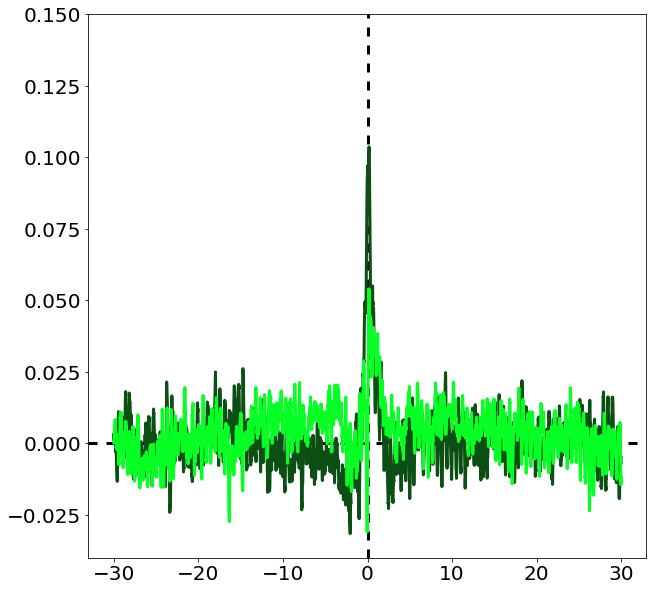

In [123]:
### LEFT TURN
plt.figure(figsize=(10,10))
plt.axhline(0,color='k',linestyle=(0,(3,3)),lw=3)
plt.axvline(0,color='k',linestyle=(0,(3,3)),lw=3)


plt.plot(bins/1000,gaussian_filter1d(neural_binned_mean['L77'],4,truncate=1),color='#0C4F14',lw=3) #0C4F14
plt.plot(bins/1000,gaussian_filter1d(neural_binned_mean['L327'],4,truncate=1),color='#08FF25',lw=3) #08FF25

plt.ylim(-.04,.15)
#plt.xlim(-5,5)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

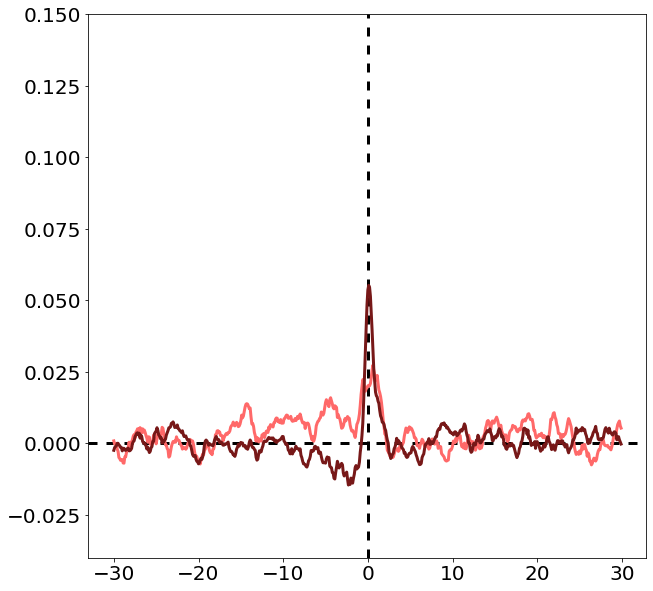

In [66]:
### LEFT TURN
plt.figure(figsize=(10,10))
plt.axhline(0,color='k',linestyle=(0,(3,3)),lw=3)
plt.axvline(0,color='k',linestyle=(0,(3,3)),lw=3)

plt.plot(bins/1000,gaussian_filter1d(neural_binned_mean['R77'],4,truncate=1),color='#FF6969',lw=3) #0C4F14
plt.plot(bins/1000,gaussian_filter1d(neural_binned_mean['R327'],4,truncate=1),color='#771818',lw=3) #08FF25

plt.ylim(-.04,.15)
#plt.xlim(-5,5)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [67]:
len(neural_binned_mean['L77'])

600

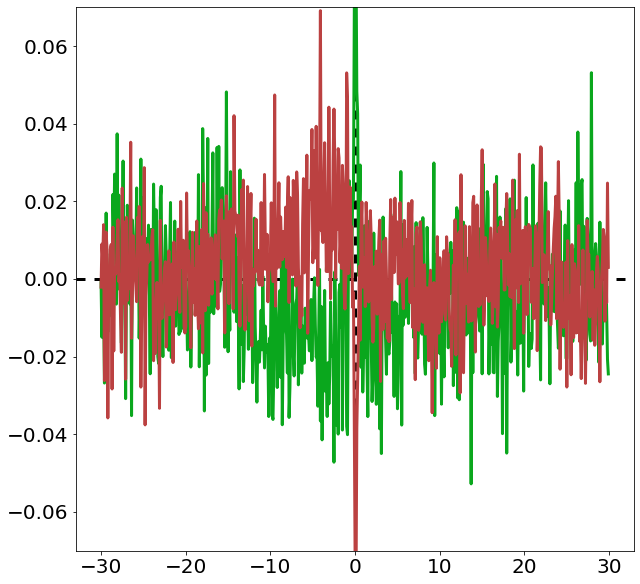

In [59]:
plt.figure(figsize=(10,10))
plt.axhline(0,color='k',linestyle=(0,(3,3)),lw=3)
plt.axvline(0,color='k',linestyle=(0,(3,3)),lw=3)
plt.plot(bins/1000,L_diff,color='#0AA71D',lw=3)
plt.plot(bins/1000,R_diff,color='#BB4141',lw=3)

plt.ylim(-.07,.07)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [15]:
from scipy.ndimage import gaussian_filter1d

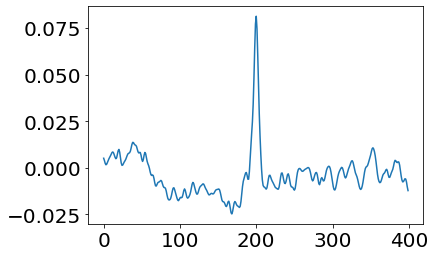

In [83]:
plt.plot(gaussian_filter1d(L_diff,2))

In [201]:
from scipy import signal

###########################
### Create Notch Filter ###
###########################

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = .5#0.2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

In [202]:
L_diff = np.asarray(neural_binned_mean['L77'])-np.asarray(neural_binned_mean['L327'])
R_diff = np.asarray(neural_binned_mean['R77'])-np.asarray(neural_binned_mean['R327'])

In [203]:
L_diff = signal.filtfilt(b_notch, a_notch, L_diff)
R_diff = signal.filtfilt(b_notch, a_notch, R_diff)

In [204]:
n = 30
L_diff = np.convolve(L_diff, np.ones(n)/n, mode='same')
R_diff = np.convolve(R_diff, np.ones(n)/n, mode='same')

In [195]:
30*20

600

In [206]:
len(L_diff)

3000

In [207]:
save_file = os.path.join(cluster_dir,'20230328_bout_triggered2')
a = gaussian_filter1d(L_diff,4,truncate=1)
b = gaussian_filter1d(R_diff,4,truncate=1)
np.save(save_file, np.stack((a,b)))

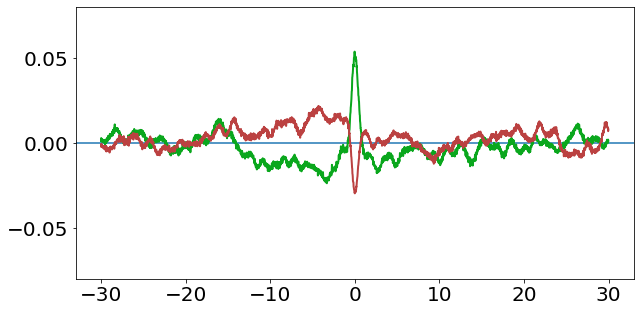

In [205]:
plt.figure(figsize=(10,5))

plt.axhline(0)

plt.plot(bins/1000,L_diff,color='#0AA71D',lw=2)
plt.plot(bins/1000,R_diff,color='#BB4141',lw=2)

plt.ylim(-.08,.08)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

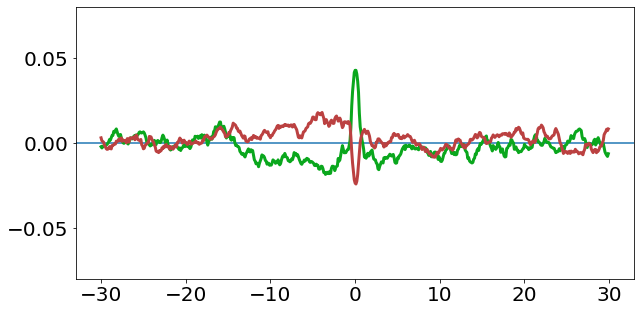

In [85]:
plt.figure(figsize=(10,5))

plt.axhline(0)
plt.plot(bins/1000,gaussian_filter1d(L_diff,4,truncate=1),color='#0AA71D',lw=3)
plt.plot(bins/1000,gaussian_filter1d(R_diff,4,truncate=1),color='#BB4141',lw=3)

plt.ylim(-.08,.08)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

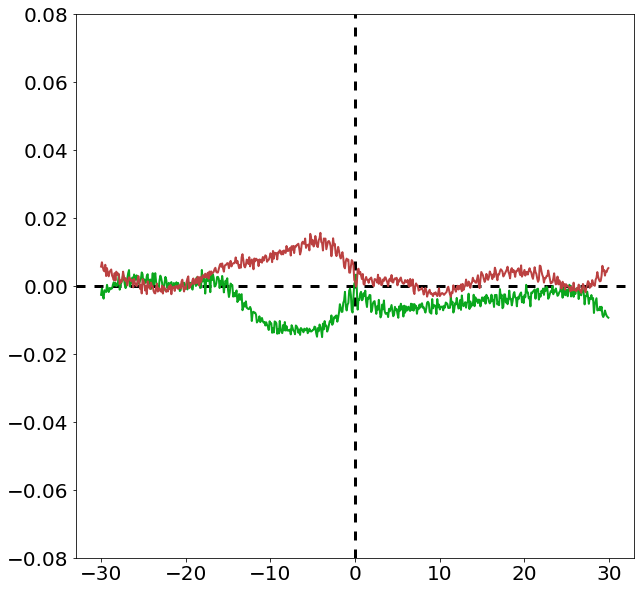

In [70]:
plt.figure(figsize=(10,10))
plt.axhline(0,color='k',linestyle=(0,(3,3)),lw=3)
plt.axvline(0,color='k',linestyle=(0,(3,3)),lw=3)

L = gaussian_filter1d(L_diff,2,truncate=1)
R = gaussian_filter1d(R_diff,2,truncate=1)

L = signal.filtfilt(b_notch, a_notch, L)
R = signal.filtfilt(b_notch, a_notch, R)

plt.plot(bins/1000,L,color='#0AA71D',lw=2)
plt.plot(bins/1000,R,color='#BB4141',lw=2)


plt.ylim(-.08,.08)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [256]:
bins[120],bins[160]

(-8000, -4000)

In [260]:
bins[240],bins[280]

(4000, 8000)

In [384]:
center_bin = 200

### -8 to -4 sec
bin_start = 120
bin_end = 160

# bin_start = 240
# bin_end = 280

all_bout_ids = {'L': [], 'R': []} #for next analysis
neural_center_fly = {'L77':[],'R77':[],'L327':[],'R327':[]} #for next analysis

neural_early = {'L77':[],'R77':[],'L327':[],'R327':[]}
neural_center = {'L77':[],'R77':[],'L327':[],'R327':[]}

for name in ['L77','R77','L327','R327']:
    for fly in range(9):

        b = bindicies_all_fly[fly][name]
        n = neural_traces_all_fly[fly][name]

        ind = np.where(np.logical_and(b>bin_start,b<bin_end))
        bout_ids = np.where(b == center_bin)[0]

        ### remove bouts without a center value
        ind_with_center = ([],[])
        for i in range(len(ind[0])):
            if ind[0][i] in bout_ids:
                ind_with_center[0].append(ind[0][i])
                ind_with_center[1].append(ind[1][i])
        ind_c = (np.asarray(ind_with_center[0]),np.asarray(ind_with_center[1]))

        ### get EARLY neural value from each bout
        bout_avg_early = []
        for bout in bout_ids:
            id_ = np.where(ind_c[0]==bout)[0]
            tps = ind_c[1][id_]
            bout_avg_early.append(np.mean(n[bout,tps]))
        neural_early[name].extend(bout_avg_early)

        ### get CENTER neural value from each bout
        bout_avg_center = []
        for bout in bout_ids:
            id_ = np.where(b[bout,:]==center_bin)[0][0]
            bout_avg_center.append(n[bout,id_])
        neural_center[name].extend(bout_avg_center)
        
        ### for next analysis ###
        if name == 'L77':
            all_bout_ids['L'].append(bout_ids)
        if name == 'R77':
            all_bout_ids['R'].append(bout_ids)
        neural_center_fly[name].append(bout_avg_center)
        ##########################

In [385]:
len(all_bout_ids_L[0]), len(neural_center_fly['L77'][0])

(69, 69)

In [387]:
##################################################
### VERSION WITH FIRST NEURAL POINT AFTER TURN ###
##################################################

neural_traces_all_fly = []
for fly in range(9):
    neural_traces = {'L77': [], 'R77': [], 'L327': [], 'R327': []}
    for cluster in [77,327]:
        z = original_z_depth[fly,cluster]
        neural_timestamps_cluster = neural_timestamps[:,z]
        for beh in ['L', 'R']:
            peaks_in_ms = fictrac_timestamps[peaks_all_fly[fly][beh]]
            for peak in peaks_in_ms:
                #this will give the index of the first neural data after the peak
                # 40 index will be the bin from 0 to 532ms after the peak
                middle = np.searchsorted(neural_timestamps_cluster,peak) 
                neural_traces[F"{beh}{cluster}"].append(supercluster_signals_fly[fly,middle-40:middle+40,cluster])
            neural_traces[F"{beh}{cluster}"] = np.asarray(neural_traces[F"{beh}{cluster}"])
    neural_traces_all_fly.append(neural_traces)

In [398]:
thresh = -.5

high_traces = {'L': np.empty((0,80)), 'R': np.empty((0,80))}
for fly in range(9):
    for beh in ['L', 'R']:
        diffs = np.asarray(neural_center_fly[F'{beh}77'][fly])-np.asarray(neural_center_fly[F'{beh}327'][fly])
        if beh == 'L':
            ind = diffs>thresh
        elif beh == 'R':
            ind = diffs<thresh
        high_bouts = all_bout_ids[beh][fly][ind]
        low_bouts = all_bout_ids[beh][fly][~ind]
        traces = neural_traces_all_fly[fly][F'{beh}77'][high_bouts,:] - neural_traces_all_fly[fly][F'{beh}327'][high_bouts,:]
        high_traces[beh] = np.concatenate((high_traces[beh], traces),axis=0)

In [394]:
len(neural_center_fly['L77'][0])

69

0.19177223040098182 0.00041602404402512624


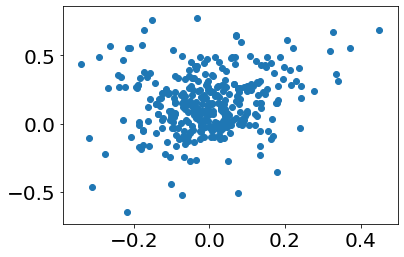

In [389]:
L_early = np.asarray(neural_early['L77']) - np.asarray(neural_early['L327'])
L_center = np.asarray(neural_center['L77']) - np.asarray(neural_center['L327'])
plt.scatter(L_early, L_center)
r,p = scipy.stats.pearsonr(L_early,L_center)
print(r,p)

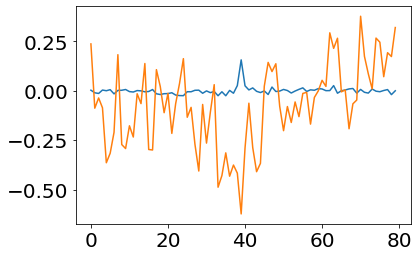

In [399]:
plt.plot(np.mean(high_traces['L'],axis=0))
plt.plot(np.mean(high_traces['R'],axis=0))

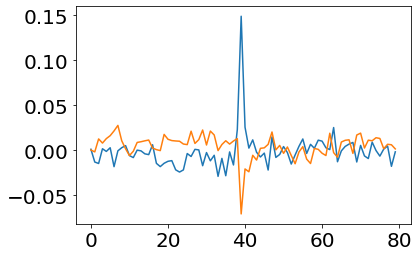

In [371]:
plt.plot(np.mean(high_traces['L'],axis=0))
plt.plot(np.mean(high_traces['R'],axis=0))

In [305]:
all_bout_ids_L[0]

array([  1,   7,  27,  28,  34,  36,  47,  48,  49,  53,  55,  56,  59,
        63,  67,  77,  80,  83,  88,  89,  92,  93,  94,  97,  99, 100,
       103, 104, 105, 107, 111, 117, 119, 121, 129, 132, 135, 137, 138,
       139, 142, 143, 145, 147, 149, 155, 157, 161, 163, 167, 168, 169,
       170, 173, 182, 187, 188, 189, 191, 193, 194, 195, 196, 198, 208,
       210, 211, 212, 214])

In [296]:
tot = 0
for i in range(9):
    tot+= len(all_bout_ids_L[i])
tot

335

In [294]:
len(peaks_all_fly[3]['L'])

47

In [ ]:
### plot diff traces after splitting based on center difference ###
# however, now there will only be ~300-400 bouts, so should switch back to the 2Hz res
# (after getting list of bouts with center value on either side of thresh)
# how do I get bout list?

In [276]:
np.asarray(neural_early['L77']).shape

(335,)

0.19177223040098182 0.00041602404402512624


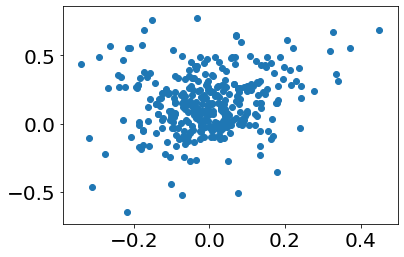

In [397]:
L_early = np.asarray(neural_early['L77']) - np.asarray(neural_early['L327'])
L_center = np.asarray(neural_center['L77']) - np.asarray(neural_center['L327'])
plt.scatter(L_early, L_center)
r,p = scipy.stats.pearsonr(L_early,L_center)
print(r,p)

In [335]:
np.sum(L_center>0)

256

0.15753387177929173 0.0007560039583482318


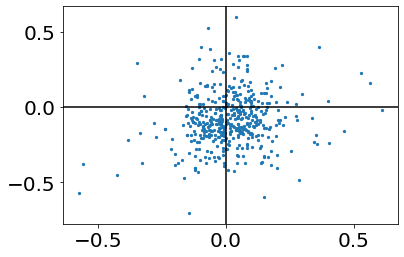

In [396]:
plt.axhline(0,color='k')
plt.axvline(0,color='k')

R_early = np.asarray(neural_early['R77']) - np.asarray(neural_early['R327'])
R_center = np.asarray(neural_center['R77']) - np.asarray(neural_center['R327'])
plt.scatter(R_early, R_center,s=5)
r,p = scipy.stats.pearsonr(R_early,R_center)
print(r,p)

In [ ]:
#pre
0.19177223040098182 0.00041602404402512624
0.15753387177929173 0.0007560039583482318

#post
0.15865542118061743 0.003597214055140969
0.11409593949907451 0.015002474923175763